# Finding the Best Experts to Follow for Fantasy Football  

If you've been playing fanasty football for a while or if this is your first season, you'll notice that the draft experts and the in-season experts are not always the same. The past several seasons, I've had a great draft and a not-so-great season. This year, I plan on following only the experts that excel at both the draft and in-season accuracy.

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

### Read and Clean the Draft Expert Rankings

In [2]:
df = pd.read_csv('FantasyPros_Fantasy_Football_Draft_Accuracy.csv')

In [3]:
def df_cleanup(df,expert='Draft_'):
    df = df.replace('-',0).set_index('Expert Name')
    df[df.columns.values] = df[df.columns.values].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    df = df.rename(columns=dict(zip(df.columns.values,[expert + col for col in df.columns.values])))
    return df

In [4]:
df = df_cleanup(df)

### Read and Clean the In-Season Expert Rankings

In [5]:
df2 = pd.read_csv('FantasyPros_Fantasy_Football_2017_SeasonToDate_Accuracy.csv')

In [6]:
df2 = df_cleanup(df2,expert='Season_')

### Join the Expert Dataframes

In [7]:
df = df.drop_duplicates(df)
df = df.drop(df.index[[0]])
df2 = df2.drop_duplicates(df2)
df2 = df2.drop(df2.index[[0]])
new_df = df.join(df2)

In [8]:
new_df = new_df[new_df['Season_Rank'] > 0]
new_df = new_df[new_df['Draft_Rank'] > 0]
new_df = new_df[['Draft_Rank','Season_Rank','Draft_QB','Season_QB',
                 'Draft_RB','Season_RB','Draft_WR','Season_WR', 'Draft_TE',
                 'Season_TE','Draft_K','Season_K','Draft_DST', 'Season_DST']]
new_df['Rank_Avg'] = new_df[['Draft_Rank', 'Season_Rank']].mean(axis=1)
new_df['Rank_Std'] = new_df[['Draft_Rank', 'Season_Rank']].std(axis=1)
new_df = new_df[new_df['Rank_Avg'] > 0]

In [9]:
new_df = new_df[np.isfinite(new_df['Rank_Std'])]

### Clustering the Experts

In [10]:
X = StandardScaler().fit_transform(new_df.values)
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))
        if bic[-1] < lowest_bic and aic[-1] < lowest_aic:
            lowest_bic = bic[-1]
            lowest_aic = aic[-1]
            best_gmm = gmm

In [11]:
best_gmm.fit(X)
expert = best_gmm.predict(X)
new_df['expert_level'] = expert

In [12]:
draft_avg = []
seas_avg = []
comp_score = []
for i in range(len(np.unique(expert))):
    draft = new_df[new_df['expert_level'] == i][['Draft_Rank']].mean(axis=0)
    seas = new_df[new_df['expert_level'] == i][['Season_Rank']].mean(axis=0)
    composite = np.mean((draft,seas))
    draft_avg.append(draft)
    seas_avg.append(seas)
    comp_score.append(composite)

In [13]:
expert_ranks = []
for i in range(len(np.unique(expert))):
    expert_ranks.append( (i,comp_score[i]) )
expert_ranks = sorted(expert_ranks, key=lambda tup: tup[1])
exp_labels = [i[0] for i in sorted(expert_ranks, key=lambda tup: tup[1])]
ordered_ranks = list(i+1 for i in range(len(expert_ranks)))
ordered_ranking = []
for i in expert:
    loc = exp_labels.index(i)
    ordered_ranking.append(ordered_ranks[loc])
new_df['expert_level'] = ordered_ranking
new_df[new_df['expert_level'] == 1][['Rank_Avg','Draft_Rank','Season_Rank']].head()

,Rank_Avg,Draft_Rank,Season_Rank
Expert Name,,,
Jason Moore - The Fantasy Footballers,8.5,3.0,14.0
Robert Waziak - Pyromaniac,6.0,5.0,7.0
Pat Fitzmaurice - The Football Girl,4.0,6.0,2.0
Jason Longfellow - Razzball,15.0,7.0,23.0
Staff Rankings - ScoutFantasy,16.0,8.0,24.0


# Plotting the Experts

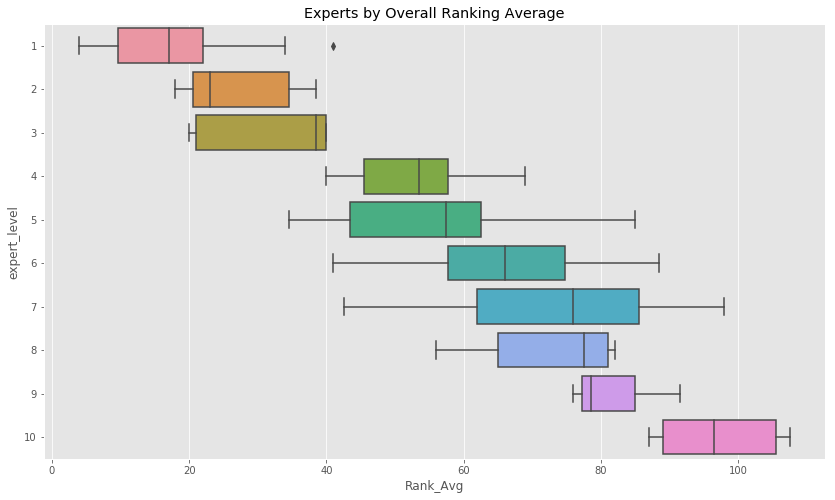

In [14]:
plt.figure(figsize=(14,8))
plt.title("Experts by Overall Ranking Average")
ax = sns.boxplot(data=new_df, x='Rank_Avg', y='expert_level', orient="h")

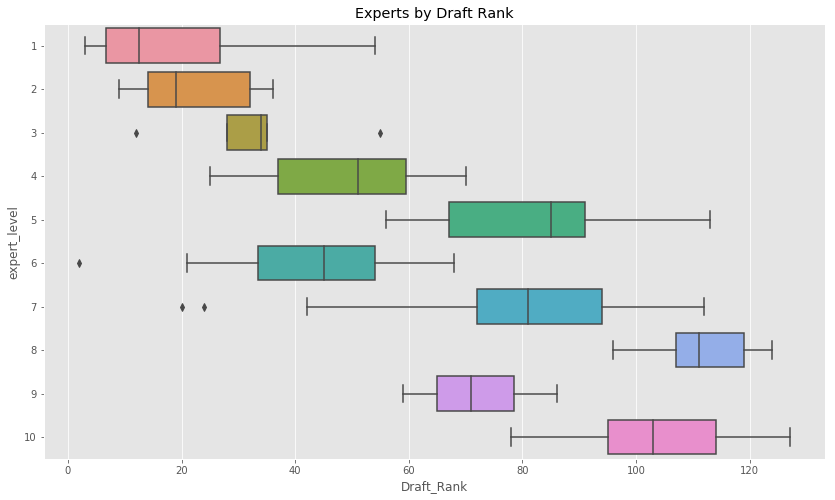

In [15]:
plt.figure(figsize=(14,8))
plt.title("Experts by Draft Rank")
ax = sns.boxplot(data=new_df, x='Draft_Rank', y='expert_level', orient="h")

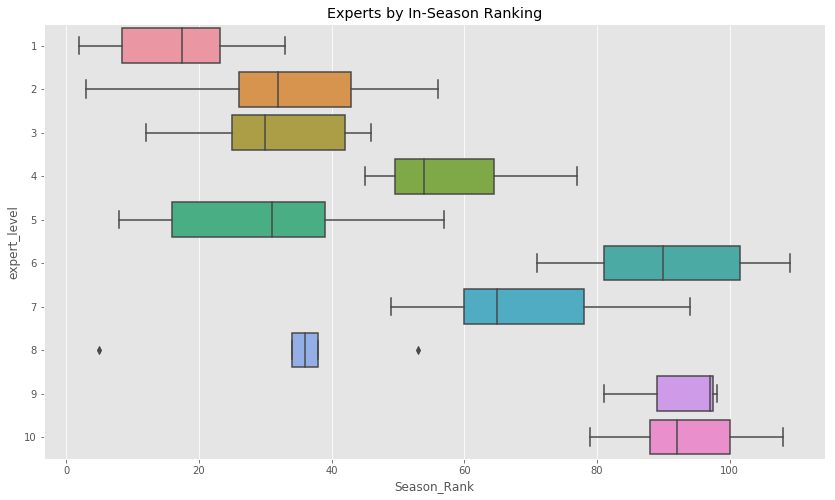

In [16]:
plt.figure(figsize=(14,8))
plt.title("Experts by In-Season Ranking")
ax = sns.boxplot(data=new_df, x='Season_Rank', y='expert_level', orient="h")

### Recommended Experts to Follow for 2018

In [17]:
new_df[new_df['expert_level'] == 1][['Draft_Rank','Season_Rank']]

,Draft_Rank,Season_Rank
Expert Name,,
Jason Moore - The Fantasy Footballers,3.0,14.0
Robert Waziak - Pyromaniac,5.0,7.0
Pat Fitzmaurice - The Football Girl,6.0,2.0
Jason Longfellow - Razzball,7.0,23.0
Staff Rankings - ScoutFantasy,8.0,24.0
Kevin Wheeler - NFL Mock,10.0,33.0
Ken Zalis - Pressbox,15.0,21.0
Justin Boone - theScore,16.0,4.0
Jeff Ratcliffe - Pro Football Focus,23.0,15.0
